<a href="https://colab.research.google.com/github/cmap/lincs-workshop-2020/blob/main/notebooks/gene_expression/Gene_modulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ACE2 Gene Modulation

### *Ted Natoli*


The goal of this notebook is to illustrate basic usage of the [`cmapR`](https://github.com/cmap/cmapR) package. As a case study, we'll be identifying compounds that down-regulate the expression of ACE2, the receptor that mediates SARS-CoV-2 cell entry.



## Setup

Here we'll install the packages required for this notebook, most notably `cmapR`. Please note that this can take a few minutes.

In [7]:
install.packages("BiocManager")
BiocManager::install("rhdf5")
devtools::install_github("cmap/cmapR", ref="lincs-workshop-2020")

# The above commands install a stripped-down version of cmapR and
# its main dependency, the rhdf5 package. The stripped-down version
# still retains most of the core functionality of the package and is
# therefore suitable for the purpose of demonstration. In practice the
# full version of cmapR can be installed with the following command:
# BiocManager::install("cmapR")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Bioconductor version 3.12 (BiocManager 1.30.10), R 4.0.3 (2020-10-10)

Installing package(s) 'BiocVersion', 'rhdf5'

also installing the dependencies ‘Rhdf5lib’, ‘rhdf5filters’


Old packages: 'pbdZMQ', 'backports', 'broom', 'gitcreds', 'htmlwidgets',
  'jsonlite', 'pkgbuild', 'ps', 'rmarkdown', 'tinytex', 'usethis', 'foreign',
  'nlme'




data.table (NA -> 1.13.4) [CRAN]


Installing 1 packages: data.table

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



✔  checking for file ‘/tmp/RtmpusCsyn/remotes3759c1d98d/cmap-cmapR-0fa345d/DESCRIPTION’
─  preparing ‘cmapR’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘cmapR_1.2.1.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Next we'll download the data files that we'll use in this notebook. This takes about a minute.

In [6]:
# download data files and assets for this notebook
system("wget --quiet -O - https://s3.amazonaws.com/repo-assets.clue.io/genemod_assets_covid.tar.gz |tar zx -C .")

In [8]:
# add pheatmap package for making heatmaps
install.packages("pheatmap")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [9]:
# load cmapR library
library(cmapR)

# load data.table for fast reading of text files
library(data.table)

# load pheatmap for plotting heatmaps
library(pheatmap)

Set up paths for matrix and metadata. In this case, we'll be using a subset of the CMap L1000 COVID data in order to minimize network file transfer. The full version of the data can be accessed at [clue.io](https://clue.io). These data are the log fold change values for each compound relative to the DMSO samples on the same detection plate.

In [10]:
ds_path <- "BICR6_logFC_genemod_n35372x868.gctx"
siginfo_path <- "siginfo_covid.txt"
geneinfo_path <- "geneinfo_covid.txt"

## Slicing a GCTX on disk

Load the metadata for all signatures. We're doing this because we don't want to load all signatures at once. The matrix is too large. So instead, we'll figure out the specific set of signatures beforehand and then extract only those. To do this we need both the `siginfo.txt` file, which contains metadata for the level 5 matrix columns.

In [11]:
# read signature annotations (corresponding to columns of level 5 matrix)
siginfo <- data.table::fread(siginfo_path)

In [12]:
str(siginfo)

Classes ‘data.table’ and 'data.frame':	76514 obs. of  10 variables:
 $ sig_id      : chr  "CALIBR001_BICR6_24H_X1_D1:A03" "CALIBR001_BICR6_24H_X1_D1:A04" "CALIBR001_BICR6_24H_X1_D1:A05" "CALIBR001_BICR6_24H_X1_D1:A06" ...
 $ pert_id     : chr  "RFM-000-178-5" "RFM-000-466-0" "RFM-000-171-8" "RFM-000-426-2" ...
 $ pert_iname  : chr  "ecopipam" "doxylamine" "gw-406381,gw406381" "proxymetacaine" ...
 $ pert_type   : chr  "trt_cp" "trt_cp" "trt_cp" "trt_cp" ...
 $ pert_idose  : chr  "5 uM" "5 uM" "5 uM" "5 uM" ...
 $ pert_itime  : chr  "24 h" "24 h" "24 h" "24 h" ...
 $ cell_id     : chr  "BICR6" "BICR6" "BICR6" "BICR6" ...
 $ ss_lfc_ge0p7: int  28 28 24 19 18 25 38 34 28 46 ...
 $ moa         : chr  "-666" "Histamine receptor antagonist" "-666" "Sodium channel inhibitor" ...
 $ target      : chr  "-666" "HRH1" "-666" "SCN10A|SCN5A" ...
 - attr(*, ".internal.selfref")=<externalptr> 


We'll also read the metadata for the genes (rows) of the level 5 matrix. This will allow us to slice along the row dimension as well.

In [13]:
# make sure we read the gene_ids as characters
geneinfo <- data.table::fread(geneinfo_path, colClasses = c("pr_gene_id" = "character"))

In [14]:
str(geneinfo)

Classes ‘data.table’ and 'data.frame':	868 obs. of  6 variables:
 $ pr_id         : chr  "218597_s_at" "201453_x_at" "203627_at" "204131_s_at" ...
 $ pr_gene_id    : chr  "55847" "6009" "3480" "2309" ...
 $ pr_gene_symbol: chr  "CISD1" "RHEB" "IGF1R" "FOXO3" ...
 $ pr_gene_title : chr  "CDGSH iron sulfur domain 1" "Ras homolog enriched in brain" "insulin-like growth factor 1 receptor" "forkhead box O3" ...
 $ pr_is_lm      : int  1 1 1 1 1 1 1 1 1 1 ...
 $ pr_is_bing    : int  0 0 0 0 0 0 0 0 0 0 ...
 - attr(*, ".internal.selfref")=<externalptr> 


Designate my gene of interest using its gene symbol.



In [15]:
my_gene <- "ACE2"

Look up the corresponding gene_id, since this will correspond to row ids in the data matrix.

In [16]:
my_gene_id <- geneinfo[pr_gene_symbol==my_gene]$pr_gene_id

Figure out list of signature ids (sig_ids) corresponding to compounds in the cell line A375, where the given signature had exactly 3 replicates. This is somewhat arbitrary but useful in reducing the number of signatures we're dealing with.

In [17]:
sigs_of_interest <- siginfo[pert_type == "trt_cp" &
                  cell_id == "BICR6" & 
                  moa != "-666"]
sig_ids <- sigs_of_interest$sig_id

How many did we get?

In [18]:
length(sig_ids)

[1] 18580

Ok, this is a pretty large number. We can pare it down by considering a random susbet of signatures, just for the purpose of loading a reasonably small number of signatures.

In [19]:
set.seed(42)
nsample <- 1e3
sigs_of_interest <- siginfo[pert_type == "trt_cp" &
                  cell_id == "BICR6" & 
                  moa != "-666"]
rand_idx <- sample.int(nrow(sigs_of_interest), nsample)
sigs_of_interest <- sigs_of_interest[rand_idx]
sig_ids <- sigs_of_interest$sig_id
length(sig_ids)

[1] 1000

Ok that's a more manageable number. Now slice out the corresponding rows and columns from the data matrix using `parse_gctx`, which will return an object of class GCT. Make sure to cast the gene_id as a character so it's not mistakenly interpreted as an integer index.

In [20]:
ds <- parse_gctx(ds_path, cid = sig_ids)

reading BICR6_logFC_genemod_n35372x868.gctx

done



Let's take a look at the structure of the object we can do this by simply typing its name.

In [21]:
ds

Formal class 'GCT' [package "cmapR"] with 7 slots
  ..@ mat    : num [1:868, 1:1000] -0.237 0.746 0.708 -1.39 0.68 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:868] "55847" "6009" "3480" "2309" ...
  .. .. ..$ : chr [1:1000] "COVID018_BICR6_24H_X2_D1:H19" "CALIBR007_BICR6_24H_X1_D1:G18" "COVID029_BICR6_24H_X2_D1:E04" "CALIBR082_BICR6_24H_X1_D2:C13" ...
  ..@ rid    : chr [1:868] "55847" "6009" "3480" "2309" ...
  ..@ cid    : chr [1:1000] "COVID018_BICR6_24H_X2_D1:H19" "CALIBR007_BICR6_24H_X1_D1:G18" "COVID029_BICR6_24H_X2_D1:E04" "CALIBR082_BICR6_24H_X1_D2:C13" ...
  ..@ rdesc  :'data.frame':	868 obs. of  1 variable:
  .. ..$ id: chr [1:868] "55847" "6009" "3480" "2309" ...
  ..@ cdesc  :'data.frame':	1000 obs. of  1 variable:
  .. ..$ id: chr [1:1000] "COVID018_BICR6_24H_X2_D1:H19" "CALIBR007_BICR6_24H_X1_D1:G18" "COVID029_BICR6_24H_X2_D1:E04" "CALIBR082_BICR6_24H_X1_D2:C13" ...
  ..@ version: chr(0) 
  ..@ src    : chr "BICR6_logFC_genemod_n35372x868.gctx"

## Analysis

### Modulation

We're interested in the data matrix, located in the slot `@mat`. This can be accessed using the `mat` function in `cmapR`. Let's look at the distribution of logFC values for ACE2. We'll add some vertical lines to indicate the thresholds for modulation.

In [22]:
# this threshold is somewhat arbitrary and can be adjusted
mod_thresh <- 0.7

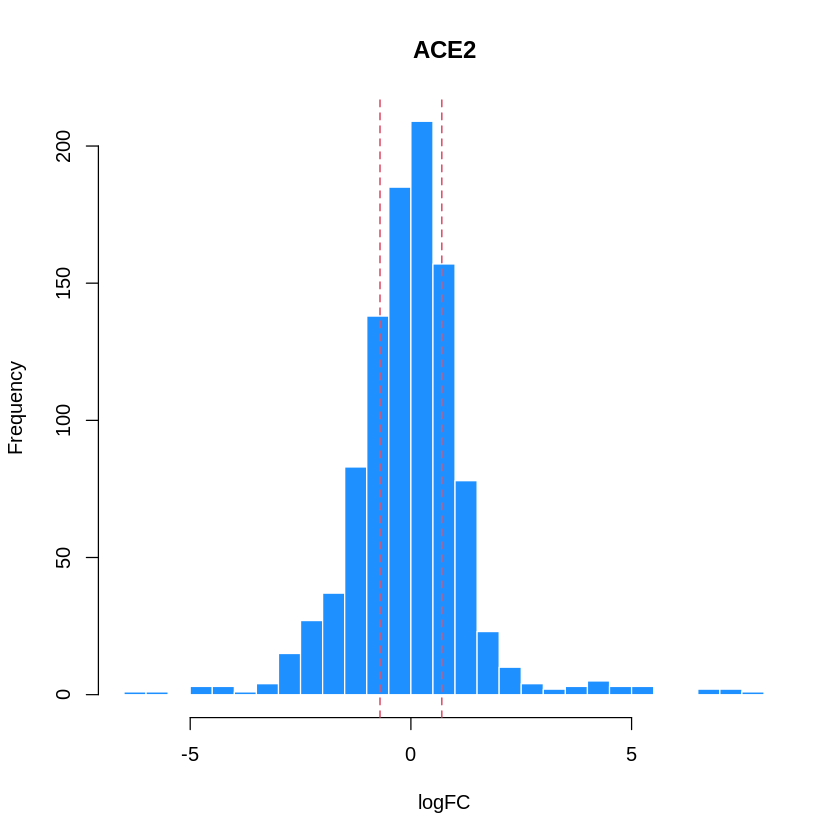

In [25]:
# subset the GCT to get just the row corresponding to ACE2
ace2_ds <- subset_gct(ds, rid=my_gene_id)
# extract the matrix
ace2_logfc <- mat(ace2_ds)
# coerce to a vector
ace2_logfc <- ace2_logfc[1, ] 
hist(ace2_logfc, col="dodgerblue", border="white", breaks=30, main=my_gene, xlab="logFC")
abline(v=mod_thresh, lty=2, col=2, lwd=1.3)
abline(v=-mod_thresh, lty=2, col=2, lwd=1.3)

### Selectivity

In addition to siginficant modulation, we also want to find signatures that selectively modlulate ACE2. That is, where ACE2 is among the most down-regulated genes for that signature. To do this, we'll simply rank the genes in each signature using the `rank_gct` function in cmapR.

In [24]:
# rank in decreasing order, so lower logFC --> lower rank
ds_ranked <- rank_gct(ds, decreasing=FALSE)
# divide by the number of genes to get a fractional rank
mat(ds_ranked) <- mat(ds_ranked) / nrow(mat(ds_ranked))

Now we'll construct a `data.table` for the logFC and fractional rank for ACE2.

In [30]:
# extract the fractional ranks as a vector
ace2_frac_rank <- mat(subset_gct(ds_ranked, rid=my_gene_id))[1, ]
# make into a data.table
ace2_df <- data.table(
  sig_id = ids(ds, dimension = "col"),
  ace2_logfc = ace2_logfc,
  ace2_frac_rank = ace2_frac_rank
)
# merge with siginfo to get other signature annotations
ace2_df <- merge(ace2_df, siginfo)
head(ace2_df)

sig_id,ace2_logfc,ace2_frac_rank,pert_id,pert_iname,pert_type,pert_idose,pert_itime,cell_id,ss_lfc_ge0p7,moa,target
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>
CALIBR001_BICR6_24H_X1_D1:A06,0.4106,0.7315668,RFM-000-426-2,proxymetacaine,trt_cp,5 uM,24 h,BICR6,19,Sodium channel inhibitor,SCN10A|SCN5A
CALIBR001_BICR6_24H_X1_D1:B12,-0.1164,0.4435484,RFM-002-649-3,fasudil,trt_cp,5 uM,24 h,BICR6,45,Rho associated kinase inhibitor,PKIA|PRKACA|ROCK1|ROCK2
CALIBR001_BICR6_24H_X1_D1:C11,0.4583,0.8029954,RFM-000-236-8,oxaprozin,trt_cp,5 uM,24 h,BICR6,29,Cyclooxygenase inhibitor,PTGS1|PTGS2
CALIBR001_BICR6_24H_X1_D1:F13,-0.2331,0.5172811,RFM-002-206-0,lomitapide,trt_cp,5 uM,24 h,BICR6,429,Microsomal trigylceride transfer protein inhibitor,MTTP
CALIBR001_BICR6_24H_X1_D1:F18,0.7132,0.7661290,RFM-003-110-7,AVL-292,trt_cp,5 uM,24 h,BICR6,127,BTK inhibitor,BTK|YES1
CALIBR001_BICR6_24H_X1_D1:G19,-1.3569,0.2903226,RFM-000-857-1,primaquine,trt_cp,5 uM,24 h,BICR6,409,Antimalarial|DNA inhibitor,KRT7|NQO2


In [33]:
# add 'selectivity' metric, which is fraction of genes more extreme
ace2_df[, selectivity := {
  ifelse(sign(ace2_logfc) == 1,
         (1 - ace2_frac_rank),
         ace2_frac_rank)
}, .(sig_id)]

Now let's make a volcano-like plot and highlight those signatures in which ACE2 is selectively down-regulated.

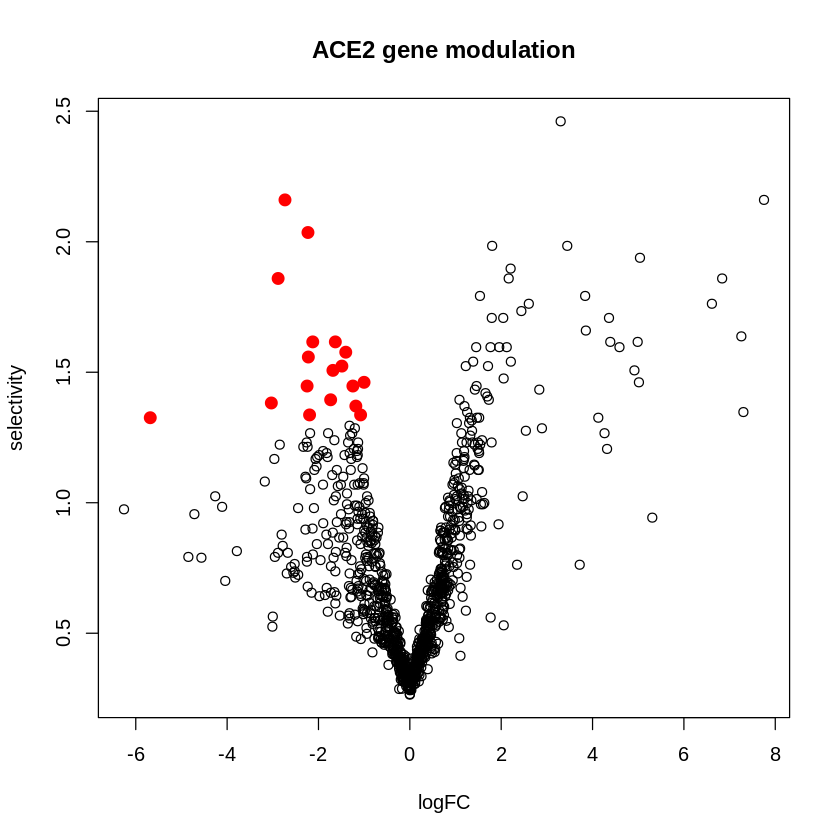

In [38]:
# volcano plot
plot(-log10(selectivity) ~ ace2_logfc, data=ace2_df,
     xlab="logFC", ylab="selectivity",
     main="ACE2 gene modulation")
with(ace2_df[ace2_logfc <= -0.7 & ace2_frac_rank <= 0.05],
     points(ace2_logfc, -log10(selectivity),
            col=rgb(1, 0, 0), pch=19, cex=1.3))

Lets identify the signatures in which the gene was significantly modulated.

In [46]:
# how many are there?
ace2_downreg <- ace2_df[ace2_logfc <= -0.7 & ace2_frac_rank <= 0.05]
nrow(ace2_downreg)

[1] 18

Let's compare these signatures to each other to see whether they have any similarity. For comparison, we'll include roughly the same number of signatures in which the ACE2 was **NOT** modulated.

In [43]:
ace2_nonmod <- ace2_df[abs(ace2_logfc) <= 0.01]
nrow(ace2_nonmod)

[1] 13

Good, this is roughly an equal number. Slice out the signatures from the matrix, restricting to landmark space (i.e. directly measured genes only).

In [47]:
lm_ids <- geneinfo[pr_is_lm == 1]$pr_gene_id
ds2 <- parse_gctx(ds_path, rid=lm_ids,
                  cid=c(ace2_downreg$sig_id, ace2_nonmod$sig_id))


reading BICR6_logFC_genemod_n35372x868.gctx

done



Compute all pairwise correlations between signatures.

In [48]:
corr <- cor(mat(ds2), method="spearman")

Cluster the correlations, overlaying a color bar indicating the degree of modulation of our gene of interest.

In [57]:
# set up a data.frame of annotations for plotting the heatmap
mod_df <- rbind(ace2_downreg, ace2_nonmod, use.names=T)
ann_df <- data.frame(ace2_logfc=mod_df$ace2_logfc)
rownames(ann_df) <- mod_df$sig_id
head(ann_df)

,ace2_logfc
,<dbl>
CALIBR008_BICR6_24H_X1_D1:N21,-1.6838
CALIBR011_BICR6_24H_X1_D1:F21,-1.4878
CALIBR018_BICR6_24H_X1_D1:B10,-1.1819
CALIBR046_BICR6_24H_X1_D2:F20,-3.0321
CALIBR052_BICR6_24H_X1_D2:D12,-1.0022
CALIBR061_BICR6_24H_X1_D2:I09,-2.8834


Plot as a heatmap using the `pheatmap` package.

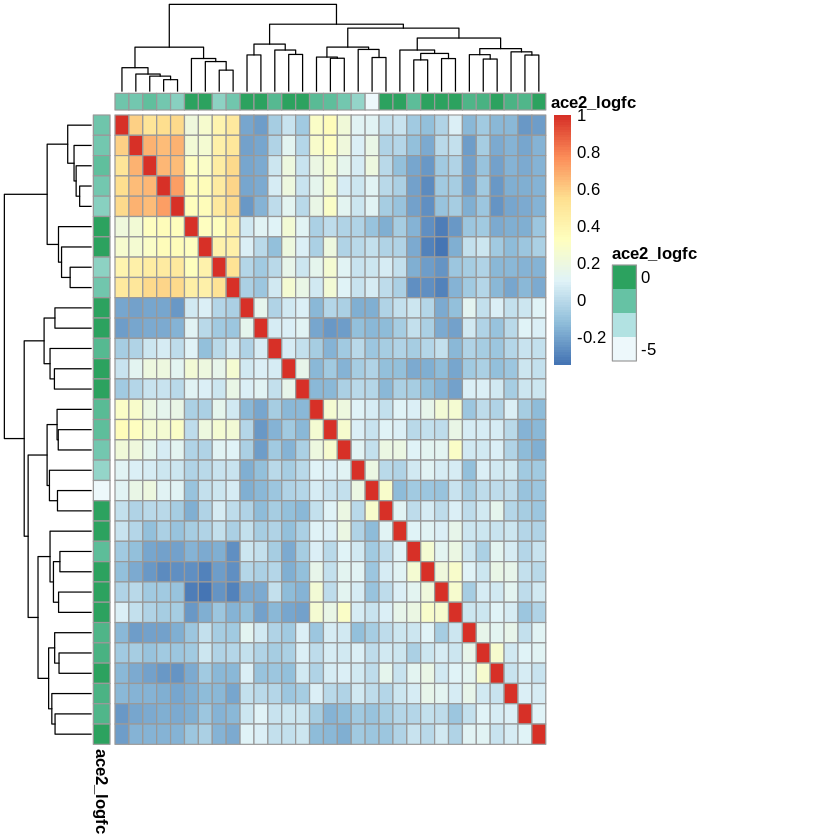

In [58]:
pheatmap::pheatmap(corr, annotation_row=ann_df, annotation_col=ann_df,
                  show_rownames=F, show_colnames=F)

Seems like we do see ~2 clusters which roughly correspond to the signatures in which our gene is modulated, as indicated by the color bar on the margins. Not perfect but definitely a trend.

Do the signatures that modulate MYC do so specifically? Let's look at the number of genes modulated in each class.

In [ ]:
ss_list <- list(
    mod = siginfo[sig_id %in% names(mod_idx)]$ss_ngene,
    non_mod = siginfo[sig_id %in% names(non_mod_idx)]$ss_ngene
)

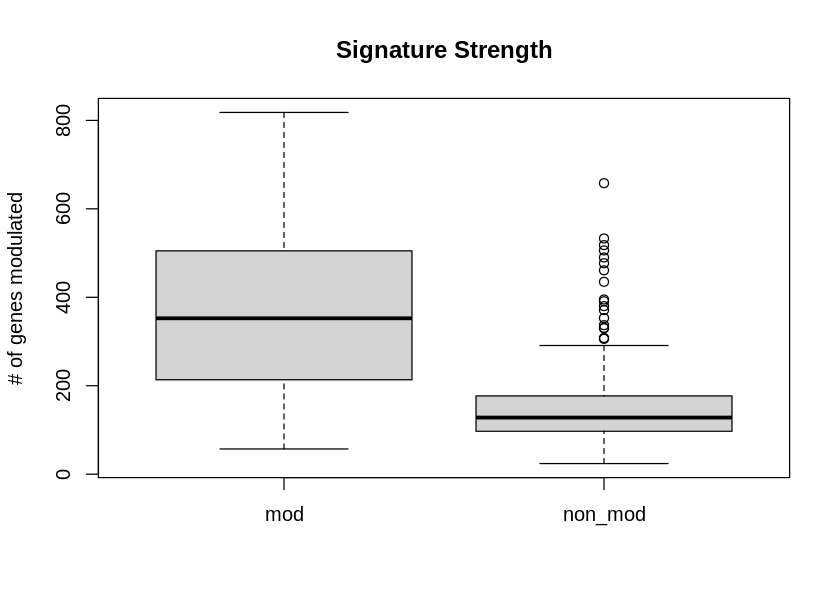

In [ ]:
boxplot(ss_list, main="Signature Strength",  ylab="# of genes modulated")

In general those compounds that modulate MYC tend to modulate lots of genes, but there are a few that are more selective. Let's look at those, and restrict to those that have a canonical name so we might have a sense of what they actually do.

In [ ]:
siginfo[sig_id %in% names(mod_idx) &
          ss_ngene <= 120
          & !grepl("^BRD-", cmap_name),
          .(sig_id, pert_id, cmap_name, ss_ngene)][
    order(ss_ngene, decreasing=F)]

sig_id,pert_id,cmap_name,ss_ngene
<chr>,<chr>,<chr>,<int>
CPC005_A375_6H:BRD-A37347161-003-01-8:10,BRD-A37347161,BRL-52537,66
REP.A002_A375_24H:D17,BRD-K16195444,oxymetazoline,68
CPC011_A375_6H:BRD-K81169441-236-06-6:10,BRD-K81169441,cerivastatin,79
CPC005_A375_6H:BRD-A15034104-002-03-6:10,BRD-A15034104,bergenin,86
MOAR003_A375_24H:G22,BRD-K90948141,indiplon,87
CPC015_A375_6H:BRD-K57033106-048-03-6:10,BRD-K57033106,tripelennamine,93
CPC017_A375_6H:BRD-A68891053-001-01-2:10,BRD-A68891053,BW-B70C,96
MOAR003_A375_24H:C12,BRD-K34332569,imidapril,99
MOAR003_A375_24H:I07,BRD-K96550715,linagliptin,108


Cervistatin is near the top of the list. Let's see which direction it regulates MYC. [This paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3491823/) suggests that perhaps statins up-regulate a specific microRNA that reduces MYC expression, albeit in a very different cell type.

In [ ]:
# use the sig_id of cervistatin to look up its impact (z-score) on MYC
round(ds@mat[, "CPC011_A375_6H:BRD-K81169441-236-06-6:10"], 2)

[1] -2.55

Indeed cervistatin down-regulates MYC, which may be in agreement with the finding in the paper above.